In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [2]:
# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)

In [3]:
energy = pd.read_csv('electricity consumption Eurostat 2023.csv')
#Time frequency: MonthlyStandard 
#international energy product classification (SIEC): Electricity
#Unit of measure: Gigawatt-hour
#Source of Data: https://ec.europa.eu/eurostat/databrowser/view/NRG_CB_EM__custom_6227363/default/table?lang=en

In [4]:
energy.head(50)

,GEO (Labels),2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
0,European Union - 27 countries (from 2020),"250,234.431","215,385.031","222,063.012","198,576.681","200,747.505","199,073.620","204,285.052","200,952.763","198,564.370","209,066.631","222,947.421","235,616.195","239,159.892","228,458.370","238,120.944","201,821.241","201,084.764","199,000.971","207,327.639","203,728.913","197,972.333","210,478.075","221,413.905","230,544.483","248,586.435","216,773.938","223,445.427","201,950.713","202,997.081","196,711.283","208,842.652","199,533.489","196,574.783","209,641.580","219,666.005","224,512.523","236,598.953","218,132.386","214,103.868","176,120.882","180,598.560","182,578.552","199,069.509","195,298.289","194,134.208","208,726.940","210,970.271","225,791.121","241,148.772","215,930.365","225,287.950","203,204.950","198,771.645","196,062.424","206,634.113","199,054.298","197,878.682","209,142.343","222,074.199","235,431.436","239,856.005","214,724.299","223,851.972","200,795.414","196,827.303","195,752.875","204,811.526","195,744.016","189,375.178","191,494.594","200,189.560","216,143.673"
1,Belgium,"7,821.644","6,778.638","7,034.123","6,480.252","6,425.014","6,322.474","6,159.814","6,283.773","6,348.503","6,842.773","7,067.314","7,439.216","7,492.472","7,130.650","7,454.690","6,427.922","6,496.643","6,355.800","6,441.420","6,385.816","6,254.323","6,773.290","6,949.913","7,194.757","7,598.430","6,688.507","6,993.838","6,391.474","6,415.349","6,132.191","6,160.416","6,242.491","6,349.651","6,826.437","7,049.161","7,199.912","7,510.720","6,995.115","6,807.619","5,787.627","6,071.529","6,117.235","6,139.197","6,364.316","6,324.405","6,736.043","6,711.446","7,225.934","7,661.795","6,777.263","7,071.967","6,720.061","6,587.673","6,427.145","6,353.601","6,400.288","6,460.112","6,884.752","7,024.456","7,367.952","7,460.893","6,681.214","6,729.608","6,343.921","6,306.094","6,158.270","6,010.169","6,169.372","5,983.643","6,055.380","6,109.907","6,646.809"
2,Bulgaria,"3,514.934","2,847.529","2,618.419","2,398.724","2,232.996","2,200.924","2,393.501","2,397.175","2,262.455","2,438.806","2,682.644","2,904.045","3,104.087","2,801.703","2,784.985","2,036.724","2,155.304","2,212.142","2,317.101","2,361.972","2,235.787","2,414.576","2,738.452","3,215.684","3,327.901","2,806.370","2,649.193","2,478.091","2,350.692","2,320.856","2,465.840","2,448.896","2,284.318","2,387.817","2,566.598","2,985.722","3,242.100","2,865.710","2,757.335","2,349.460","2,166.811","2,159.043","2,378.525","2,321.958","2,241.829","2,379.931","2,737.874","2,949.284","3,123.580","2,803.770","3,028.845","2,623.781","2,257.185","2,328.040","2,567.360","2,551.744","2,236.577","2,530.742","2,661.143","3,086.540","3,263.426","2,784.076","3,134.053","2,449.024","2,299.635","2,257.064","2,445.539","2,403.419","2,185.173","2,314.383","2,563.547","2,967.922"
3,Czechia,"6,358.719","5,423.970","5,517.405","5,011.044","4,883.905","4,634.410","4,439.907","4,650.574","4,746.667","5,244.115","5,577.755","5,635.755","5,922.149","5,649.188","6,013.260","4,821.882","4,823.044","4,681.789","4,586.606","4,774.112","4,643.543","5,248.375","5,587.603","5,666.716","6,230.192","5,445.047","5,587.586","4,987.519","5,081.291","4,674.029","4,583.680","4,662.247","4,724.159","5,223.525","5,479.198","5,538.540","6,046.774","5,500.085","5,494.874","4,385.871","4,465.521","4,410.868","4,443.015","4,520.956","4,673.722","5,202.345","5,447.441","5,620.963","6,084.635","5,659.643"

In [5]:
#i can take Croatia and do a prediction of consumption over time using SARIMA

In [6]:
transposed_energy = energy.transpose()

In [7]:
transposed_energy.head(22)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
GEO (Labels),European Union - 27 countries (from 2020),Belgium,Bulgaria,Czechia,Denmark,Germany (until 1990 former territory of the FRG),Estonia,Ireland,Greece,Spain,France,Croatia,Italy,Cyprus,Latvia,Lithuania,Luxembourg,Hungary,Malta,Netherlands,Austria,Poland,Portugal,Romania,Slovenia,Slovakia,Finland,Sweden,Iceland,Norway,United Kingdom,Bosnia and Herzegovina,Montenegro,Moldova,North Macedonia,Albania,Serbia,Türkiye,Ukraine,Kosovo (under United Nations Security Council ...,Georgia
2017-01,"250,234.431","7,821.644","3,514.934","6,358.719","3,148.502","44,805.424",844.000,"2,586.093","5,550.875","21,976.280","52,369.482","1,564.787","28,280.000",426.486,697.000,980.897,588.741,"3,680.027",210.608,"10,094.000","6,487.446","12,933.792","4,514.483","5,217.000","1,224.784","2,701.000","8,240.000","13,417.427","1,591.566","12,944.446","29,545.861","1,273.513",960.000,:,710.609,:,"3,887.823","24,338.515",:,:,:
2017-02,"215,385.031","6,778.638","2,847.529","5,423.970","2,823.321","39,758.565",754.000,"2,359.048","4,481.545","18,986.816","40,523.681","1,286.883","25,256.000",358.529,627.000,904.876,518.557,"3,237.214",176.034,"9,066.000","5,573.772","12,243.193","3,861.736","4,662.000","1,080.615","2,334.000","7,411.000","12,050.509","1,456.590","11,799.788","25,810.212","1,017.982","1,388.000",:,570.708,:,"3,111.174","21,779.229",:,:,:
2017-03,"222,063.012","7,034.123","2,618.419","5,517.405","2,927.113","42,711.611",779.000,"2,510.063","4,492.349","20,158.962","39,660.507","1,306.641","26,585.000",339.013,646.000,925.929,561.178,"3,285.658",185.369,"9,508.000","5,701.377","12,509.605","4,075.055","4,729.000","1,155.908","2,352.000","7,589.000","12,198.727","1,648.040","12,048.433","26,054.870","1,015.055",925.000,:,557.568,:,"3,001.000","22,970.517",:,:,:
2017-04,"198,576.681","6,480.252","2,398.724","5,011.044","2,605.766","38,904.428",699.000,"2,258.380","3,989.165","18,065.551","33,734.991","1,211.586","23,730.000",302.027,581.000,851.953,510.459,"3,145.458",170.669,"8,297.000","5,137.276","11,672.605","3,594.788","4,299.000","1,056.259","2,187.000","6,912.000","10,770.300","1,530.738","10,345.456","23,679.868",979.291,788.000,:,514.758,:,"2,705.976","21,470.679",:,:,:
2017-05,"200,747.505","6,425.014","2,232.996","4,883.905","2,599.848","39,615.961",652.000,"2,239.168","4,212.741","19,570.857","32,294.990","1,245.244","25,636.000",341.594,567.000,896.462,513.683,"3,257.216",177.217,"8,685.000","5,091.377","12,085.781","3,831.841","4,310.000","1,113.236","2,157.000","6,319.000","9,792.374","1,566.680","9,110.429","24,274.720",925.630,832.000,:,474.393,:,"2,491.177","22,403.722",:,:,:
2017-06,"199,073.620","6,322.474","2,200.924","4,634.410","2,491.297","38,157.073",583.000,"2,138.488","4,653.002","20,852.065","30,798.969","1,293.801","27,941.000",397.436,528.000,851.860,517.360,"3,291.767",203.130,"8,547.000","5,001.528","11,802.408","3,899.895","4,205.000","1,122.704","2,250.000","5,649.000","8,740.029","1,491.724","8,003.852","22,835.135",955.437,841.000,:,428.590,:,"2,467.634","22,095.769",:,:,:
2017-07,"204,285.052","6,159.814","2,393.501","4,439.907","2,386.236","39,099.056",572.000,"2,200.177","5,618.209","21,653.505","31,196.854","1,476.996","30,019.000",558.245,540.000,823.067,538.648,"3,260.706",254.103,"8,225.000","5,128.008","11,879.326","4,072.642","4,462.000","1,110.436","2,129.000","5,724.000","8,364.616","1,534.431","7,787.181","23,335.970","1,010.719",892.000,:,472.494,:,"2,530.303","27,331.803",:,:,:
2017-08,"200,952.763","6,283.773","2,397.175","4,650.574","2,601.937","39,816.399",624.000,"2,202.882","5,451.123","21,144.478","29,512.055","1,512.198","26,912.000",509.325,574.000,918.584,470.155,"3,358.131",267.212,"8,009.000","5,100.821","12,019.601","3,889.866","4,482.000","1,088.783","2,188.000","6,052.000","8,916.691","1,540.540","8,254.078","23,468.727",999.384,936.000,:,486.798,:,"2,595.496","2

In [8]:
transposed_energy.columns.values.tolist() 


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40]

In [9]:
new_columns=transposed_energy.loc['GEO (Labels)'].values.tolist()
new_columns

['European Union - 27 countries (from 2020)',
 'Belgium',
 'Bulgaria',
 'Czechia',
 'Denmark',
 'Germany (until 1990 former territory of the FRG)',
 'Estonia',
 'Ireland',
 'Greece',
 'Spain',
 'France',
 'Croatia',
 'Italy',
 'Cyprus',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Hungary',
 'Malta',
 'Netherlands',
 'Austria',
 'Poland',
 'Portugal',
 'Romania',
 'Slovenia',
 'Slovakia',
 'Finland',
 'Sweden',
 'Iceland',
 'Norway',
 'United Kingdom',
 'Bosnia and Herzegovina',
 'Montenegro',
 'Moldova',
 'North Macedonia',
 'Albania',
 'Serbia',
 'Türkiye',
 'Ukraine',
 'Kosovo (under United Nations Security Council Resolution 1244/99)',
 'Georgia']

In [10]:
transposed_energy.columns = new_columns

In [11]:
transposed_energy.head(10)

,European Union - 27 countries (from 2020),Belgium,Bulgaria,Czechia,Denmark,Germany (until 1990 former territory of the FRG),Estonia,Ireland,Greece,Spain,France,Croatia,Italy,Cyprus,Latvia,Lithuania,Luxembourg,Hungary,Malta,Netherlands,Austria,Poland,Portugal,Romania,Slovenia,Slovakia,Finland,Sweden,Iceland,Norway,United Kingdom,Bosnia and Herzegovina,Montenegro,Moldova,North Macedonia,Albania,Serbia,Türkiye,Ukraine,Kosovo (under United Nations Security Council Resolution 1244/99),Georgia
GEO (Labels),European Union - 27 countries (from 2020),Belgium,Bulgaria,Czechia,Denmark,Germany (until 1990 former territory of the FRG),Estonia,Ireland,Greece,Spain,France,Croatia,Italy,Cyprus,Latvia,Lithuania,Luxembourg,Hungary,Malta,Netherlands,Austria,Poland,Portugal,Romania,Slovenia,Slovakia,Finland,Sweden,Iceland,Norway,United Kingdom,Bosnia and Herzegovina,Montenegro,Moldova,North Macedonia,Albania,Serbia,Türkiye,Ukraine,Kosovo (under United Nations Security Council ...,Georgia
2017-01,"250,234.431","7,821.644","3,514.934","6,358.719","3,148.502","44,805.424",844.000,"2,586.093","5,550.875","21,976.280","52,369.482","1,564.787","28,280.000",426.486,697.000,980.897,588.741,"3,680.027",210.608,"10,094.000","6,487.446","12,933.792","4,514.483","5,217.000","1,224.784","2,701.000","8,240.000","13,417.427","1,591.566","12,944.446","29,545.861","1,273.513",960.000,:,710.609,:,"3,887.823","24,338.515",:,:,:
2017-02,"215,385.031","6,778.638","2,847.529","5,423.970","2,823.321","39,758.565",754.000,"2,359.048","4,481.545","18,986.816","40,523.681","1,286.883","25,256.000",358.529,627.000,904.876,518.557,"3,237.214",176.034,"9,066.000","5,573.772","12,243.193","3,861.736","4,662.000","1,080.615","2,334.000","7,411.000","12,050.509","1,456.590","11,799.788","25,810.212","1,017.982","1,388.000",:,570.708,:,"3,111.174","21,779.229",:,:,:
2017-03,"222,063.012","7,034.123","2,618.419","5,517.405","2,927.113","42,711.611",779.000,"2,510.063","4,492.349","20,158.962","39,660.507","1,306.641","26,585.000",339.013,646.000,925.929,561.178,"3,285.658",185.369,"9,508.000","5,701.377","12,509.605","4,075.055","4,729.000","1,155.908","2,352.000","7,589.000","12,198.727","1,648.040","12,048.433","26,054.870","1,015.055",925.000,:,557.568,:,"3,001.000","22,970.517",:,:,:
2017-04,"198,576.681","6,480.252","2,398.724","5,011.044","2,605.766","38,904.428",699.000,"2,258.380","3,989.165","18,065.551","33,734.991","1,211.586","23,730.000",302.027,581.000,851.953,510.459,"3,145.458",170.669,"8,297.000","5,137.276","11,672.605","3,594.788","4,299.000","1,056.259","2,187.000","6,912.000","10,770.300","1,530.738","10,345.456","23,679.868",979.291,788.000,:,514.758,:,"2,705.976","21,470.679",:,:,:
2017-05,"200,747.505","6,425.014","2,232.996","4,883.905","2,599.848","39,615.961",652.000,"2,239.168","4,212.741","19,570.857","32,294.990","1,245.244","25,636.000",341.594,567.000,896.462,513.683,"3,257.216",177.217,"8,685.000","5,091.377","12,085.781","3,831.841","4,310.000","1,113.236","2,157.000","6,319.000","9,792.374","1,566.680","9,110.429","24,274.720",925.630,832.000,:,474.393,:,"2,491.177","22,403.722",:,:,:
2017-06,"199,073.620","6,322.474","2,200.924","4,634.410","2,491.297","38,157.073",583.000,"2,138.488","4,653.002","20,852.065","30,798.969","1,293.801","27,941.000",397.436,528.000,851.860,517.360,"3,291.767",203.130,"8,547.000","5,001.528","11,802.408","3,899.895","4,205.000","1,122.704","2,250.000","5,649.000","8,740.029","1,491.724","8,003.852","22,835.135",955.437,841.000,:,428.590,:,"2,467.634","22,095.769",:,:,:
2017-07,"204,285.052","6,159.814","2,393.501","4,439.907","2,386.236","39,099.056",572.000,"2,200.177","5,618.209","21,653.505","31,196.854","1,476.996","30,019.000",558.245,540.000,823.067,538.648,"3,260.706",254.103,"8,225.000","5,128.008","11,879.326","4,072.642","4,462.000","1,110.436","2,129.000","5,724.000","8,364.616","1,534.431","7,787.181","23,335.970","1,010.719",892.000,:,472.494,:,"2,530.303","27,331.803",:,:,:
2017-08,"200,952.763","6,2

In [12]:
croatia =  transposed_energy[['Croatia']].copy()
#dataframe just for Croatia

In [13]:
croatia.head()

,Croatia
GEO (Labels),Croatia
2017-01,"1,564.787"
2017-02,"1,286.883"
2017-03,"1,306.641"
2017-04,"1,211.586"


In [14]:
type(croatia)

pandas.core.frame.DataFrame

In [15]:
croatia.columns.values.tolist() 

['Croatia']

In [16]:
 croatia1=croatia[1:]

In [17]:
 croatia1

,Croatia
2017-01,"1,564.787"
2017-02,"1,286.883"
2017-03,"1,306.641"
2017-04,"1,211.586"
2017-05,"1,245.244"
...,...
2022-08,"1,454.093"
2022-09,"1,280.696"
2022-10,"1,244.484"
2022-11,"1,295.632"


In [18]:
croatia1['GEO (Labels)'] = croatia1.index
#i will create new column in data frame from index column, to get a date column for time series 

C:\Users\kates\AppData\Local\Temp\ipykernel_9960\264406346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  croatia1['GEO (Labels)'] = croatia1.index


In [19]:
croatia1.head(10)

,Croatia,GEO (Labels)
2017-01,"1,564.787",2017-01
2017-02,"1,286.883",2017-02
2017-03,"1,306.641",2017-03
2017-04,"1,211.586",2017-04
2017-05,"1,245.244",2017-05
2017-06,"1,293.801",2017-06
2017-07,"1,476.996",2017-07
2017-08,"1,512.198",2017-08
2017-09,"1,279.742",2017-09
2017-10,"1,317.891",2017-10


In [20]:
croatia_new = croatia1[['GEO (Labels)', 'Croatia']]
#i will put date column first

In [21]:
croatia_new

,GEO (Labels),Croatia
2017-01,2017-01,"1,564.787"
2017-02,2017-02,"1,286.883"
2017-03,2017-03,"1,306.641"
2017-04,2017-04,"1,211.586"
2017-05,2017-05,"1,245.244"
...,...,...
2022-08,2022-08,"1,454.093"
2022-09,2022-09,"1,280.696"
2022-10,2022-10,"1,244.484"
2022-11,2022-11,"1,295.632"


In [22]:
 #i will check for null values and fill with median value if there are ; no null values
croatia_new.isnull().sum()

GEO (Labels)    0
Croatia         0
dtype: int64

In [23]:
#now i will check data types to see if i have a date type column for time series
croatia_new.dtypes

GEO (Labels)    object
Croatia         object
dtype: object

In [24]:
#i will first rename column GEO (Labels) to date
#df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)

croatia_new.rename(columns={'GEO (Labels)':'Date','Croatia':'Cro_energy_consumption'}, inplace=True)

In [25]:
# convert the 'Date' column to datetime format
#df['Date']= pd.to_datetime(df['Date'])
# Check the format of 'Date' column
#df.info()

In [26]:
croatia_new 

,Date,Cro_energy_consumption
2017-01,2017-01,"1,564.787"
2017-02,2017-02,"1,286.883"
2017-03,2017-03,"1,306.641"
2017-04,2017-04,"1,211.586"
2017-05,2017-05,"1,245.244"
...,...,...
2022-08,2022-08,"1,454.093"
2022-09,2022-09,"1,280.696"
2022-10,2022-10,"1,244.484"
2022-11,2022-11,"1,295.632"


In [27]:
# #pandas to_datetime function to parse the column as DateTime. Also, by using infer_datetime_format=True, 
# it will automatically detect the format and convert the mentioned column to DateTime 

croatia_new['Date'] =  pd.to_datetime(croatia_new['Date'], infer_datetime_format=True)

In [28]:
croatia_new.dtypes

Date                      datetime64[ns]
Cro_energy_consumption            object
dtype: object

In [29]:
croatia_new


,Date,Cro_energy_consumption
2017-01,2017-01-01,"1,564.787"
2017-02,2017-02-01,"1,286.883"
2017-03,2017-03-01,"1,306.641"
2017-04,2017-04-01,"1,211.586"
2017-05,2017-05-01,"1,245.244"
...,...,...
2022-08,2022-08-01,"1,454.093"
2022-09,2022-09-01,"1,280.696"
2022-10,2022-10-01,"1,244.484"
2022-11,2022-11-01,"1,295.632"


In [30]:
start_date =datetime(2017,1,1)
end_date = datetime(2022,12,1)

In [31]:
# croatia_new = croatia_new.reset_index()
# print(croatia_new.head())

In [32]:
# croatia_new = croatia_new.index(drop=True)
# print(croatia_new.head())
#i made a number index to be able to use index for parts of plots
croatia_new = croatia_new.reset_index(drop=True)
print(croatia_new.head(20))

         Date Cro_energy_consumption
0  2017-01-01              1,564.787
1  2017-02-01              1,286.883
2  2017-03-01              1,306.641
3  2017-04-01              1,211.586
4  2017-05-01              1,245.244
5  2017-06-01              1,293.801
6  2017-07-01              1,476.996
7  2017-08-01              1,512.198
8  2017-09-01              1,279.742
9  2017-10-01              1,317.891
10 2017-11-01              1,352.745
11 2017-12-01              1,485.334
12 2018-01-01              1,428.198
13 2018-02-01              1,402.999
14 2018-03-01              1,516.406
15 2018-04-01              1,234.845
16 2018-05-01              1,314.899
17 2018-06-01              1,304.858
18 2018-07-01              1,458.603
19 2018-08-01              1,534.060


In [33]:
#croatia_new['Cro_energy_consumption'].apply(lambda x: x.replace(',',''))

In [34]:
#croatia_new['Cro_energy_consumption'] = croatia_new['Cro_energy_consumption'].astype(str)

In [35]:
#croatia_new['Cro_energy_consumption'] = croatia_new['Cro_energy_consumption'].apply(lambda x: x.strip())

In [36]:
# croatia_new['Cro_energy_consumption'] = croatia_new['Cro_energy_consumption'].astype(float)

# df['your_col'].str.replace('\u2010', '-', regex=False).astype(float)

croatia_new['Cro_energy_consumption'].str.replace(',', '', regex=False).astype(float)

0     1564.787
1     1286.883
2     1306.641
3     1211.586
4     1245.244
        ...   
67    1454.093
68    1280.696
69    1244.484
70    1295.632
71    1452.834
Name: Cro_energy_consumption, Length: 72, dtype: float64

In [37]:
#now I will check how data looks like

In [38]:
#croatia_new['Cro_energy_consumption'] = croatia_new['Cro_energy_consumption'].astype(float)

croatia_new['Cro_energy_consumption'] = [float(str(i).replace(",", "")) for i in croatia_new['Cro_energy_consumption']]

In [39]:

croatia_new.dtypes

Date                      datetime64[ns]
Cro_energy_consumption           float64
dtype: object

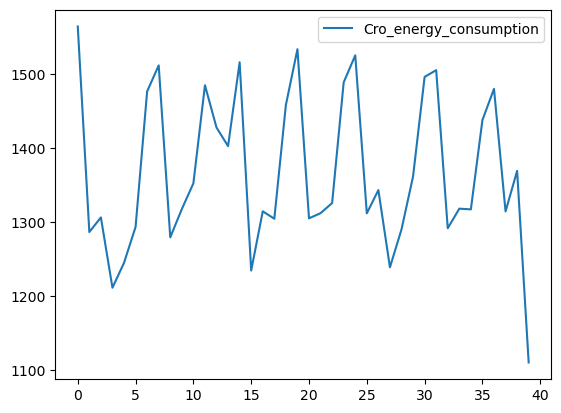

In [40]:
croatia_new.iloc[0:40].plot(y='Cro_energy_consumption')
plt.show()

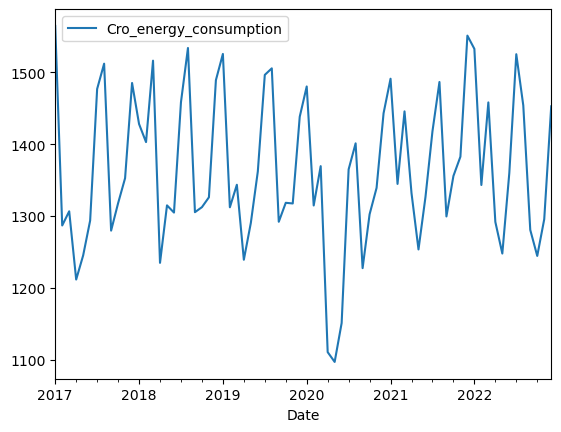

In [41]:
croatia_new.iloc[0:72].plot(x='Date', y='Cro_energy_consumption')
plt.show()

In [42]:
croatia_new=croatia_new.set_index('Date')

In [43]:
croatia_new

,Cro_energy_consumption
Date,
2017-01-01,1564.787
2017-02-01,1286.883
2017-03-01,1306.641
2017-04-01,1211.586
2017-05-01,1245.244
...,...
2022-08-01,1454.093
2022-09-01,1280.696
2022-10-01,1244.484


In [44]:
croatia_new.dtypes

Cro_energy_consumption    float64
dtype: object

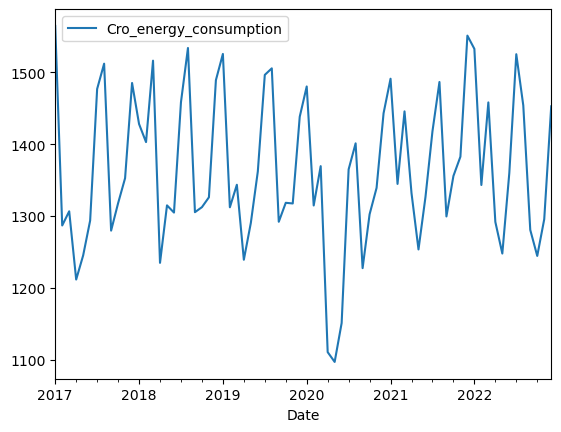

In [45]:
croatia_new.iloc[0:72].plot (y='Cro_energy_consumption')
plt.show()

In [46]:
# The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not.
#Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis
#based on the resulting p-value.

# Null Hypothesis: The data is not stationary.

# Alternative Hypothesis: The data is stationary.

# For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:
# # p-value <= significance level (0.01, 0.05, 0.10, etc.)

# #https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/
# What is stationary vs non-stationary data in time series?
# Introduction to Non-Stationary Processes
# When a time series is stationary, it means that certain attributes of the data do
# not change over time. However, some time series are non-stationary, whereby values 
# and associations between and among variables do vary with time. 
# In finance, many processes are non-stationary, and so must be handled appropriate.

In [47]:
adf = adfuller(croatia_new)
adf
#as seasonality is visible, data cant be stationary; still doing a ADF test

(-1.7745434116277996,
 0.3931713973846929,
 12,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 676.3279248325151)

In [48]:
print('ADF Statistic: %f' % adf[0])
print('Critical Values @ 0.05: %.2f' % adf [4]['5%'])
print('p-value: %f' % adf[1])

ADF Statistic: -1.774543
Critical Values @ 0.05: -2.91
p-value: 0.393171


In [49]:
#p value iz larger then 0,05
# The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

# There is no reason to reject the null hypothesis.The data is not stationary.


In [50]:
#REMOVING A TREND, monthly data, oduzimam vrijednosti u svakoj tocki ovog miseca s prethodnim. dobijes stabilnu deltu
#razliku izmedju miseca i miseca, tj stabilnu vrijednost rasta otprilike
#non- stationary data znaci da postoji neki trend ponavljanja prema gore ili dole..kad se mice razlika u rastu miče se i ternd
# Our time series dataset may contain a trend.

# A trend is a continued increase or decrease in the series over time. 
# There can be benefit in identifying, modeling, and even removing trend information from your time series dataset.
# Removing a Trend
# A time series with a trend is called non-stationary.

# An identified trend can be modeled. Once modeled, it can be removed from the time series dataset. 
# This is called detrending the time series.

# If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be trend stationary.
#https://machinelearningmastery.com/time-series-trends-in-python/

# micanje trenda 8.misec-7.misec, ostane delta razlika t dva mieca, 
# a micanje sezonalnosti je 8 misec ove mnus 8.misec npr prosle godine,isto ostane delta, ali cile sezone,
# tako da prvo treba odredit koliko veliki raspon do ponavljanja sezone postoji da se vidi koliko godina unazad 
# 8.misec ove od koliko godina unazad 8.miseca koje godine moramo oduzet


In [51]:
croatia_new_notrend=croatia_new.diff()[1:]

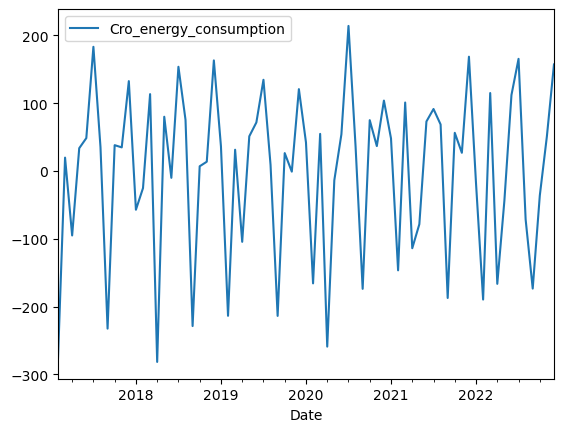

In [52]:
croatia_new_notrend.iloc[0:72].plot (y='Cro_energy_consumption')
plt.show()

In [53]:
croatia_new_notrend.columns.values.tolist() 


['Cro_energy_consumption']

In [54]:
# #now we need to remove seasonality, take tests to see what order we need to take 
# # Autocorrelation Function and Partial Autocorrelation Function, ACF & PACF
# # Order of AR, MA, and ARMA Model
# Autocorrelation Function and Partial Autocorrelation Function
# Autocorrelation Function (ACF)
# Correlation between time series with a lagged version of itself. 
# The correlation between the observation at the current time spot and the observations at previous time spots.
# The autocorrelation function starts a lag 0, 
# # which is the correlation of the time series with itself and therefore results in a correlation of 1.
# # KOLIKO SLIČI NA SAMU SEBE I OPET NA OVU DRUGU ZNAČI DA SE TAD PONAVLJA U TOJ GODINI SEZONALNOST KREĆE
# Partial Autocorrelation Function (PACF)
# Additional correlation explained by each successive lagged term. The correlation between pbservations 
# at two time spots given that we consider both observations are correlated 
# to observations at other time spots.
# Both the ACF and PACF start with a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

# The difference between ACF and PACF is the inclusion or exclusion of indirect correlations in the calculation.

# Furthermore, you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval 
# and is in indicator for the significance threshold. That means, anything within the blue area is
# statistically close to zero and anything outside the blue area is statistically non-zero.
# How do I choose AR or MA?
# You would choose an AR model if you believe that previous observations have
# a direct effect on the time series. You would choose an MA model if you believe
# that the weighted sum of differences (errors) have a direct effect on the time series.18. lis 2019.

# When to use AR and when to use MA model? - Cross Validated
# https://stats.stackexchange.com/questions/432010/when-to-use-ar-and-when-to-use-ma-model

In [55]:
#seasonality, finding orders

In [56]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
#from statsmodels.tsa.statespace import SARIMAX
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

<BarContainer object of 12 artists>

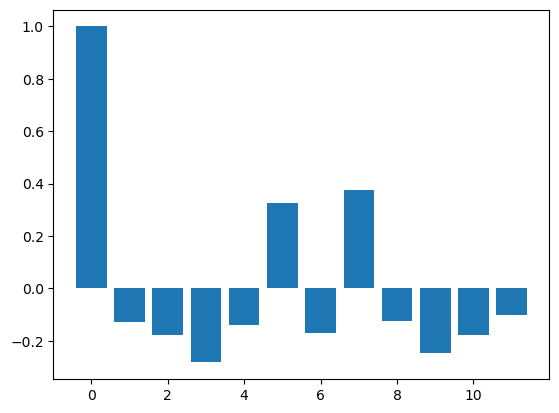

In [57]:
#na tablici na kojoj je maknut trend croatia_new_notrend
acf_vals = acf(croatia_new_notrend)
num_lags = 12 
#(stavila 50 ispravi te koliko ih ima)
plt.bar(range(num_lags), acf_vals[:num_lags])

In [58]:
#we see that after 12 months lag something significant changes, so it is seasonal change with lag of 
#12 months

In [59]:
croatia_new_notrend.shape[0]

71

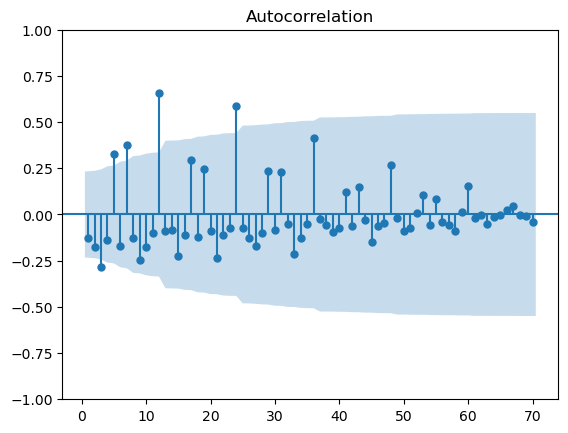

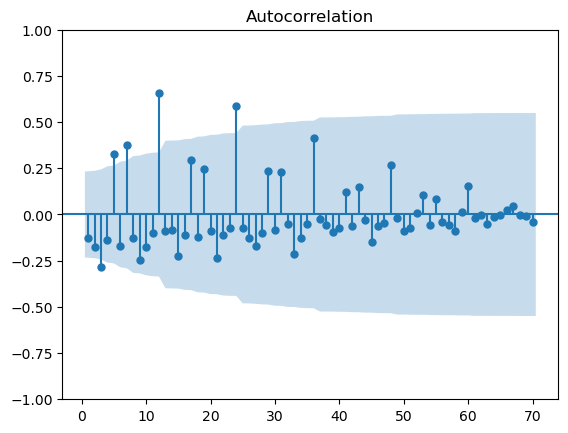

In [60]:
#na tablici na kojoj je maknut trend croatia_new_notrend
plot_acf(croatia_new_notrend, lags = 70, zero = False) 
#zero false preskoci prvi mjesec

In [61]:
# pacf_vals = pacf(croatia_new_notrend)
# num_lags=2
# #(stavila 50 ispravi te koliko ih ima)
# plt.bar(range(num_lags), pacf_vals[:num_lags])

# # #ValueError: nlags = 40
# #   1032     if nlags >= x.shape[0] // 2:

D:\Nova mapa (3)\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


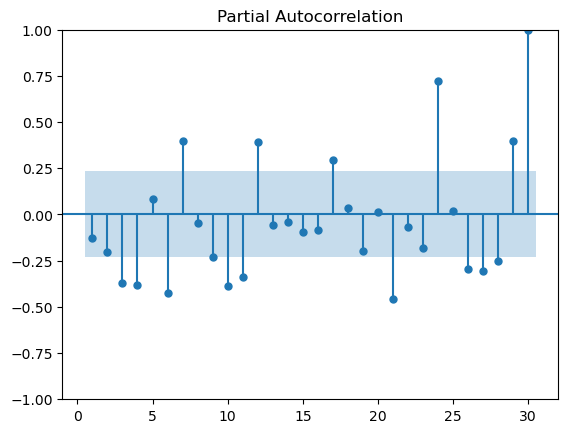

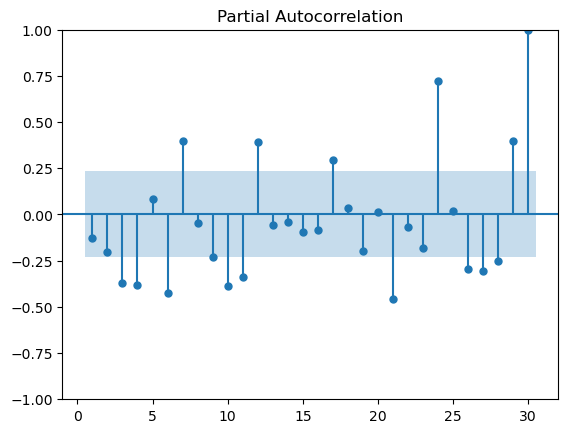

In [62]:
plot_pacf(croatia_new_notrend, lags = 30, zero = False)

In [63]:
#svakih 12 mj iskaču vrhovi 

In [64]:

#za provjeru najboljeg modela

In [65]:
# # results = pm.auto_arima(croatia_new, seasonal = True, m = 12, d=1, D=1, information_criterion = "bic",
# trace= True, error_Action = "ignore", n_fits=40, stepwise = True) )
# #ide prva tablica ne ova s maknutim trendom

In [66]:
# #posli u sarimi prvi dio zagrade je nonseasonal part a drugi dio seasonal part..jel utjece ili ne na 
# Understanding the ARIMA Model
# The “I” stands for integrated, which means that the data is stationary. 
# Stationary data refers to time-series data that's been made “stationary”
# by subtracting the observations from the previous values.28. pro 2022.
# Autoregressive Integrated Moving Average (ARIMA)
# u stationary je I=1

# po meni u 1 god tj NEsezonalnosti, ar=0, ne ovisi jedan misec o prethodnom koliko se troši energije
# ma, moving average=1 postoji, i I je stationary jer smo tako napravili
# u sezonalnosti je ar= 0 jer opet ne ovisi o prethodnom ili ovisi ako maknemo sezonalnost, onda delata ovisi o prethodnom
# ma je 0 jer si maka da prosjek isti s je 0 jer si maka sezonalnost i broj i je 0 jer maka stacionarnost,
# a m je 12 jer se svakih 12 mj ponavlja sezonalnost
# zaporavo to se psie umisto s je nula,jer se sezonalnost i mora maknit da bi se radile procjene
# po onom coviku s papirića pogledaj


In [67]:
#***** acf je za ma, q broj
# q= 3 (do 12.mjeseca pa krece sezonalnost)

In [68]:
#***** pacf je za ar autoregressive, p broj
# p=6 (do 12.mjeseca pa krece sezonalnost), možda 7 probat ću 6

In [69]:
# d = 1 za micanje integrated 

In [70]:
# m=4 je u 12 mj se tako kreću podatci 
# P Q i D za sezonalni dio;
# rekla bi
# P=1
# D=0 (jer ostaje sezonalnost, nismo je micali, tako da broj oduzetih vremenskih perioda za micanje sezonalnosti 0,
#     a broj micati vremeski serija za micanje trenda 1 jer smo micali trend ako i postoji..to ovo integrated..iako mogli i nula
#     ostat https://www.youtube.com/watch?v=Al8m6K_stfA)
# Q=1

In [71]:
Cro_energy_consumption2 = croatia_new['Cro_energy_consumption'] 

In [72]:

#******VAŽNO KATE IZVOR PODATAKA ZA TRAIN I TEST SI UZELA KOLONU SAMO POTROŠNJE ENERGIJE I TO PRVE TABLICE NE DRUGE
#UZELA SI PODATKE KOLONE ALI PRVE TABLICE KOJA NIJE S MAKNUTIM TRENDOM, NE CROATIA_NEW_NOTREND NEGO IZ CROATIA_NEW
#NIJE DOBRO ISPADALO KAD IZ OVE S MAKNUTIM TRENDOM, JER PRVI PODATCI ULAZNI NARAVNO IZ OVE BEZ MAKNUTOG TRENDA,
#DAKLE PREDIKCIJA SE NA NJU TREBA NASTAVIT
#PRVO PROBALA IZ OVE S MAKNUTIM TRENDOM I PODATCI SE NISU NASTAVILI NEGO BILI DOLE NA DNU


In [73]:
#na tablici prvotnoj ne onoj s koje je maknut trend
train_start = datetime(2017,1,1)
#test_start
train_end = datetime(2021,7,1)
test_end = datetime(2022,12,1)
train_data = Cro_energy_consumption2[train_start:train_end]
test_data= Cro_energy_consumption2[train_end:test_end]

In [74]:
my_order = (8,1,3)
my_seasonal_order = (1,0,1,12)
#model saima
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

D:\Nova mapa (3)\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Nova mapa (3)\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [75]:
#fitting model
start = time()
model_fit=model.fit()
end=time()
print('Model fitting time is:', end-start)

Model fitting time is: 0.5357885360717773


D:\Nova mapa (3)\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [76]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:               Cro_energy_consumption   No. Observations:                   55
Model:             SARIMAX(8, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -300.154
Date:                              Sat, 20 May 2023   AIC                            628.307
Time:                                      16:22:40   BIC                            656.153
Sample:                                  01-01-2017   HQIC                           639.046
                                       - 07-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1402      0.623     -1.830      0.067      -2.362       0.081
ar.L2          0.20

In [77]:
#getting predictions and residuals
predictions = model_fit.forecast(len(test_data))

#predictions = pd.Series(predictions, index=test_data.index)
#test_data= croatia_new [train_end + timedelta(days= 1):test_end]
#residuals = test_data-predictions


In [78]:
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data-predictions
residuals
#NAN JER SE NEMA OD ČEGA ODUZETI PRVI PODATAK

Date
2021-07-01          NaN
2021-08-01    33.554724
2021-09-01    -2.502934
2021-10-01    46.456641
2021-11-01    14.343623
2021-12-01    96.673943
2022-01-01    34.280230
2022-02-01    10.914929
2022-03-01    64.995840
2022-04-01    48.967739
2022-05-01     3.539146
2022-06-01    58.302739
2022-07-01    91.640299
2022-08-01   -21.735524
2022-09-01    -5.369353
2022-10-01   -69.781659
2022-11-01   -52.919858
2022-12-01    -6.463638
dtype: float64

Text(0, 0.5, 'Error SARIMA')

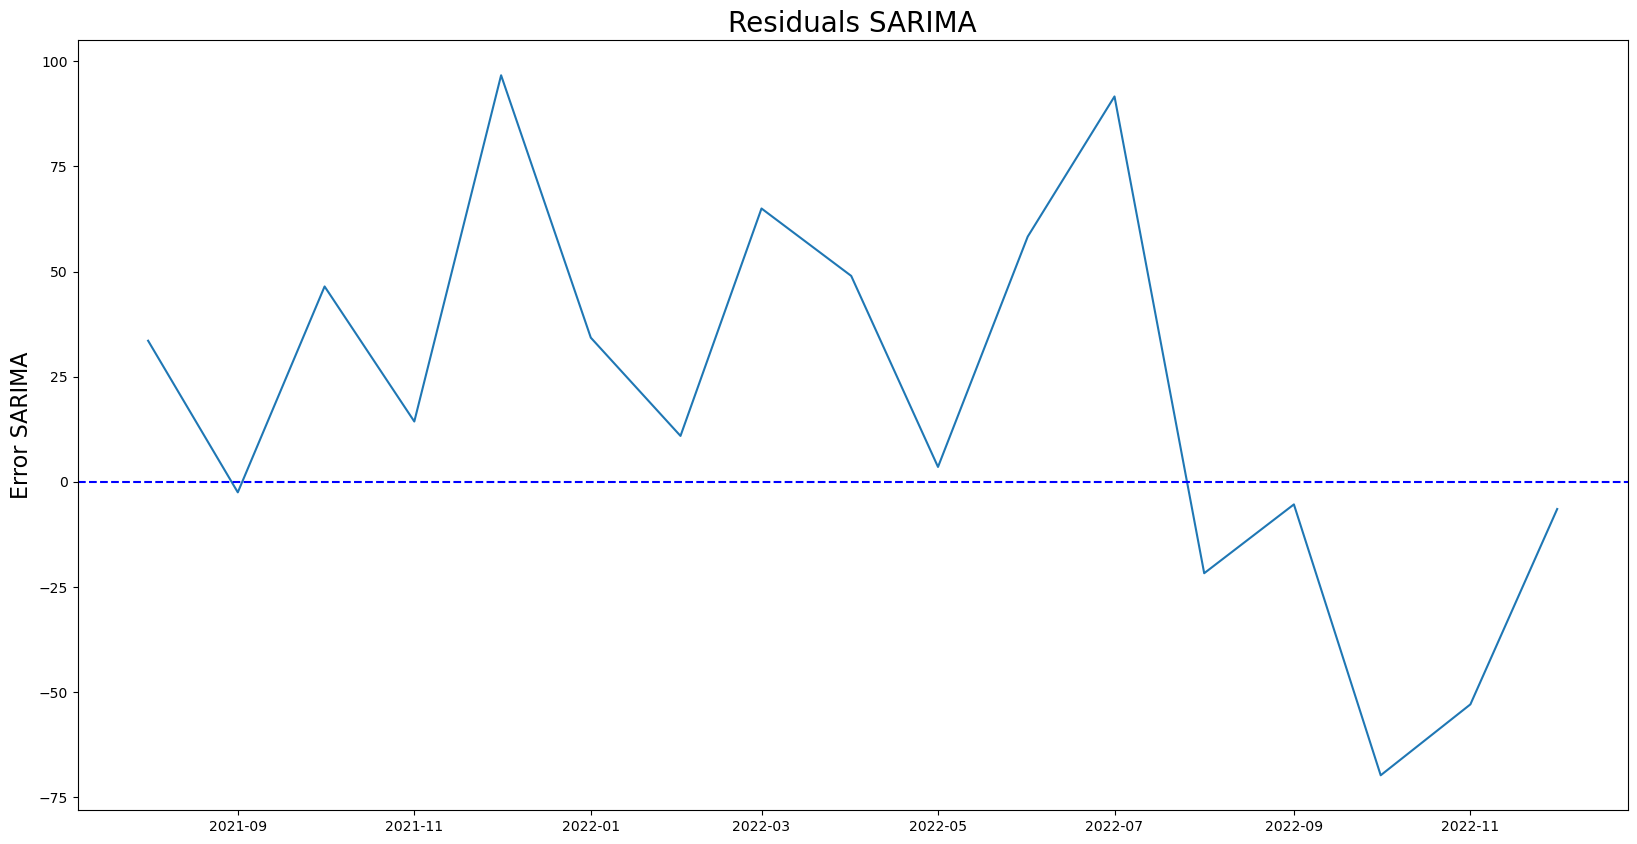

In [79]:
plt.figure(figsize=(20,10))
plt.plot(residuals)
plt.axhline(0,linestyle='--', color='blue')
plt.title('Residuals SARIMA', fontsize=20)
plt.ylabel('Error SARIMA', fontsize=16)

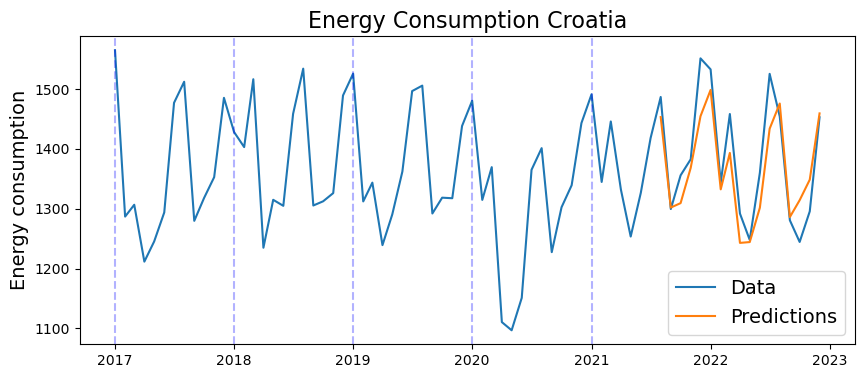

In [86]:
plt.figure(figsize=(10,4))
plt.plot(croatia_new)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=14)
plt.title('Energy Consumption Croatia', fontsize=16)
plt.ylabel('Energy consumption', fontsize = 14)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+ '-01-01'), color='blue', linestyle='--', alpha=0.3) 

In [87]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error:  0.0277


In [88]:
import math
MSE = np.square(np.subtract(test_data,predictions)).mean() 
 
RMSE = math.sqrt(MSE)
 

print('Root Mean Squared Error: ', RMSE)
      
      

Root Mean Squared Error:  48.97855181882494


In [89]:
def rmse(predictions, test_data):
      return np.sqrt(((predictions - test_data) ** 2).mean())

rmse= rmse(predictions, test_data)

In [90]:
print('Root Mean Squared Error: ', rmse)

Root Mean Squared Error:  48.97855181882494


In [91]:
#Rolling predictions, predvidja se 1 mjesec pa svaki iduci po prethodnom stanju

In [92]:
Cro_energy_consumption3=Cro_energy_consumption2.asfreq(pd.infer_freq(Cro_energy_consumption2.index))

In [93]:
#na tablici prvotnoj ne onoj s koje je maknut trend
train_start2 = datetime(2017,1,1)
#test_start
train_end2 = datetime(2021,7,1)
test_end2 = datetime(2022,12,1)
train_data2 = Cro_energy_consumption3[train_start2:train_end2]
test_data2= Cro_energy_consumption2[train_end2:test_end2]

In [94]:
#rolling predictions
rolling_predictions = test_data.copy()

for train_end2 in test_data.index:
    train_data2 = Cro_energy_consumption3[:train_end2-timedelta(days=1)]
    model2=SARIMAX(train_data2, order=my_order, seasonal_order=my_seasonal_order)
    model2_fit=model2.fit()
    
    pred=model2_fit.forecast()
    rolling_predictions[train_end2]=pred
    
    

D:\Nova mapa (3)\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
D:\Nova mapa (3)\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Nova mapa (3)\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Nova mapa (3)\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Nova mapa (3)\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimizatio

LinAlgError: LU decomposition error.

In [96]:
rolling_residuals=test_data2-rolling_predictions

Text(0, 0.5, 'Error SARIMA')

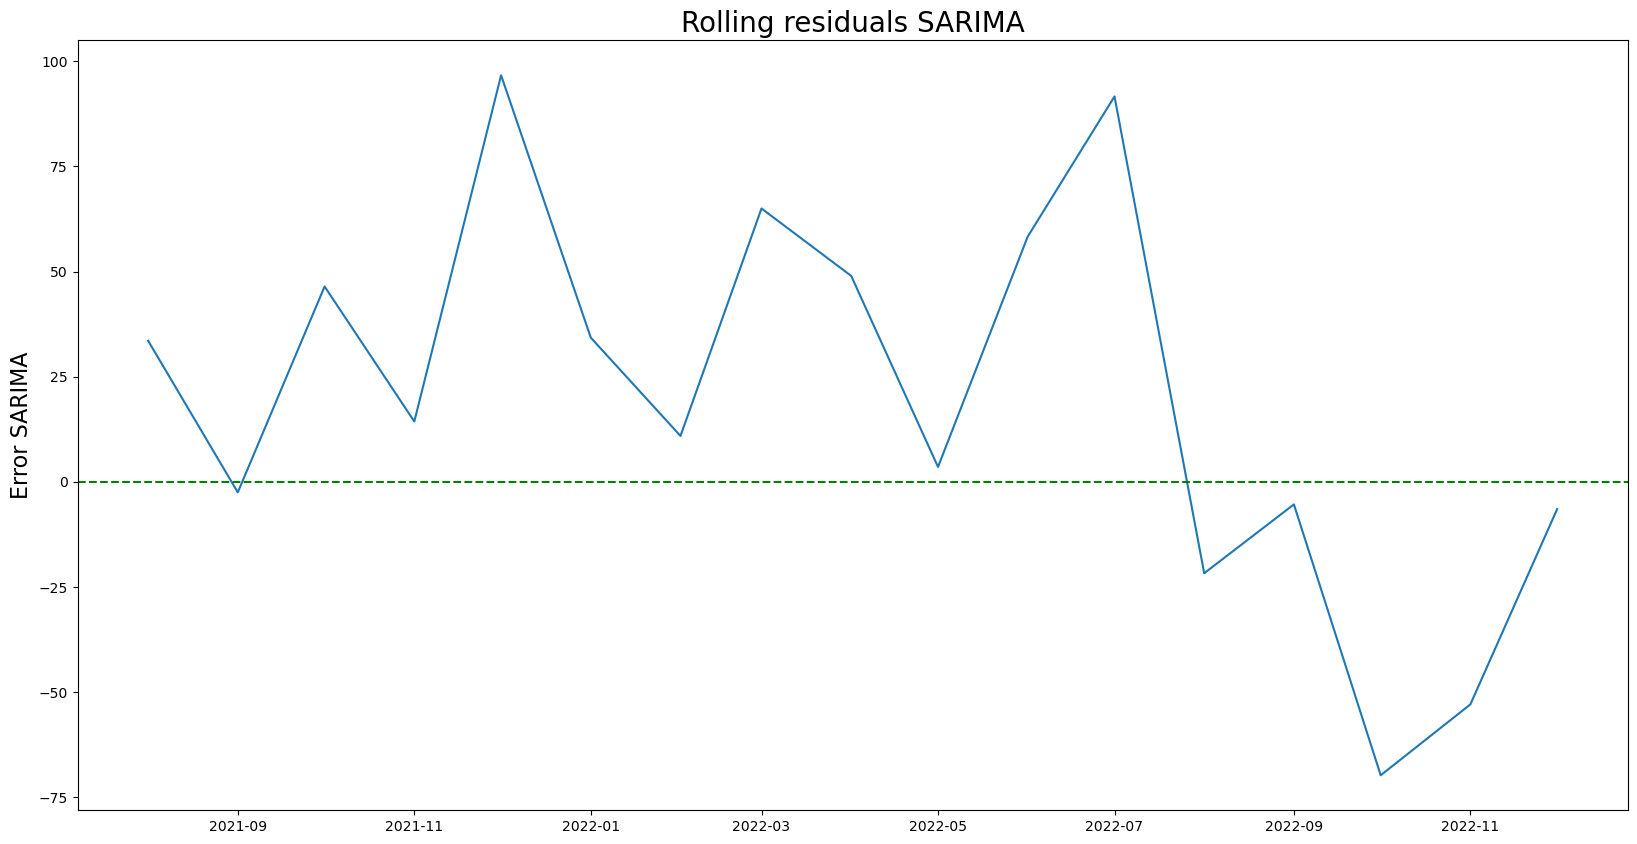

In [101]:
plt.figure(figsize=(20,10))
plt.plot(residuals)
plt.axhline(0,linestyle='--', color='green')
plt.title('Rolling residuals SARIMA', fontsize=20)
plt.ylabel('Error SARIMA', fontsize=16)

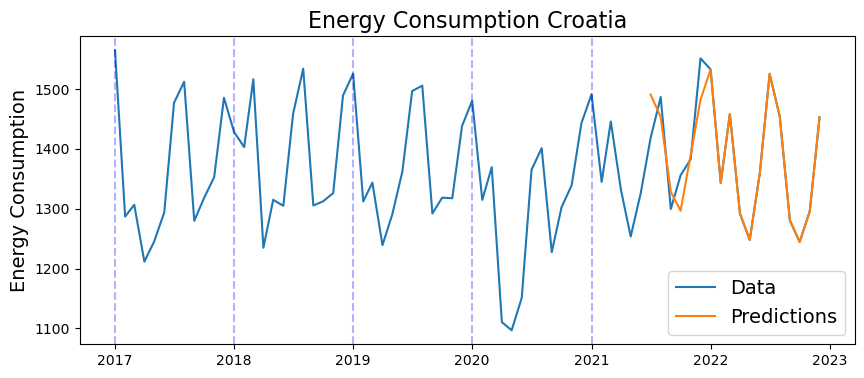

In [105]:
plt.figure(figsize=(10,4))
plt.plot(croatia_new)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=14)
plt.title('Energy Consumption Croatia', fontsize=16)
plt.ylabel('Energy Consumption', fontsize = 14)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+ '-01-01'), color='blue', linestyle='--', alpha=0.3) 

In [106]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error:  0.0106


In [107]:
import math
MSE = np.square(np.subtract(test_data,rolling_predictions)).mean() 
 
RMSE = math.sqrt(MSE)
 

print('Root Mean Squared Error: ', RMSE)
      

Root Mean Squared Error:  29.494782875841576
